In [1]:
import json
import ROOT
from analysis_framework import Dataset
from WWAnalysis import WWAnalysis
import os
from alt_setup_creator import AltSetupHandler

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x6d82400


In [2]:
ROOT.EnableImplicitMT(12)

In [3]:
# CLD
# x_angle = 0.030 # rad
# ILD
x_angle = 0.014 # rad

In [4]:
prod = True
no_rvec = False
# output_collections = r"(\w*sqme\w*)|(weight\w*)"
dataset_path = "stage2-test.json"
template_par_plot_path = "plots/template_parametrisation/test"
histo_path = "data/histograms/test"
# # output_path = "data/snapshots/stage2-test"
# output_meta = "stage2-test.json"
if prod:
    dataset_path = "stage2-full.json"
    template_par_plot_path = "plots/template_parametrisation/full"
    histo_path = "data/histograms/full"
    # output_path = "data/snapshots/stage2"
    # output_meta = "stage2-full.json"

In [5]:
dataset = Dataset.from_json(dataset_path)

In [6]:
analysis = WWAnalysis(dataset)
analysis.init_categories()

In [7]:
alt_setup_handler = AltSetupHandler("alt-configs.json", mirror=True)
alt_configs = alt_setup_handler.get_alt_setup()
alt_variations = alt_setup_handler.get_variations()

In [8]:
# check if we missed any processes
print(analysis.is_complete_categorisation())
signal_category = ["4f_sw_sl_signal"]
analysis.set_signal_categories(signal_category)

True


In [9]:
print(json.dumps(analysis._categories, indent=2))

{
  "4f_sw_sl_signal": [
    "4f_sw_sl_eLpL_signal",
    "4f_sw_sl_eLpR_signal",
    "4f_sw_sl_eRpR_signal",
    "4f_sw_sl_eRpL_signal"
  ],
  "4f_sl_bkg": [
    "4f_zz_sl_eLpR",
    "4f_zz_sl_eRpL",
    "4f_zznu_sl_eLpR",
    "4f_zznu_sl_eRpL",
    "4f_sze_sl_eLpL",
    "4f_sze_sl_eLpR",
    "4f_sze_sl_eRpR",
    "4f_sze_sl_eRpL",
    "4f_sznu_sl_eLpR",
    "4f_sznu_sl_eRpL",
    "4f_ww_sl_eLpR",
    "4f_ww_sl_eRpL",
    "4f_sw_sl_eLpL_bkg",
    "4f_sw_sl_eLpR_bkg",
    "4f_sw_sl_eRpR_bkg",
    "4f_sw_sl_eRpL_bkg"
  ],
  "4f_not_sl": [
    "4f_zz_h_eLpR",
    "4f_zz_h_eRpL",
    "4f_zz_l_eLpR",
    "4f_zz_l_eRpL",
    "4f_zzorww_h_eLpR",
    "4f_zzorww_l_eLpR",
    "4f_zzorww_l_eRpL",
    "4f_zznu_l_eLpR",
    "4f_zznu_l_eRpL",
    "4f_sznu_l_eLpR",
    "4f_sznu_l_eRpL",
    "4f_sze_l_eLpL",
    "4f_sze_l_eLpR",
    "4f_sze_l_eRpR",
    "4f_sze_l_eRpL",
    "4f_szeorsw_l_eLpL",
    "4f_szeorsw_l_eLpR",
    "4f_szeorsw_l_eRpR",
    "4f_szeorsw_l_eRpL",
    "4f_sw_l_eLpL",
    "4f_sw_l_

In [10]:
oo_setups = ["g1z_pos_1em05", "ka_pos_1em05", "la_pos_1em05", ]
analysis.define_optimal_observables(alt_setup_handler, only=oo_setups)

In [11]:
n_bins = 20
oo_configs = {
    "O_g1z_pos_1em05": ("", "O_g1z_pos_1em05", n_bins, -3.5, 3.5),
    "O_ka_pos_1em05":  ("", "O_ka_pos_1em05", n_bins, -3.5, 3.5),
    "O_la_pos_1em05":  ("", "O_la_pos_1em05", n_bins, -3.5, 3.5),
}
for name, config in oo_configs.items():
    analysis.book_histogram_1D(name, name, config)

In [12]:
weights = [f"weight_{name}" for name in ["nominal"] + list(alt_configs.keys())]
analysis._define(("weight_nominal", "1.0"), signal_category)
analysis.book_templates(oo_configs, weights, signal_category)
analysis.book_oo_matrix(list(oo_configs.keys()))

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x1798c170


In [13]:
%%time
analysis.run()

CPU times: user 16.8 s, sys: 663 ms, total: 17.4 s
Wall time: 12.5 s


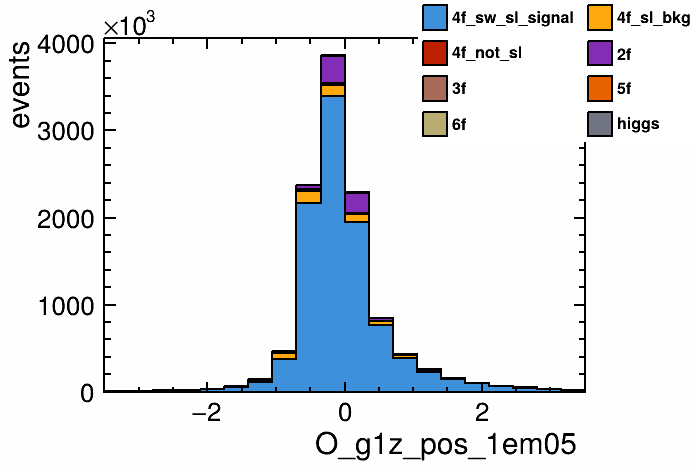

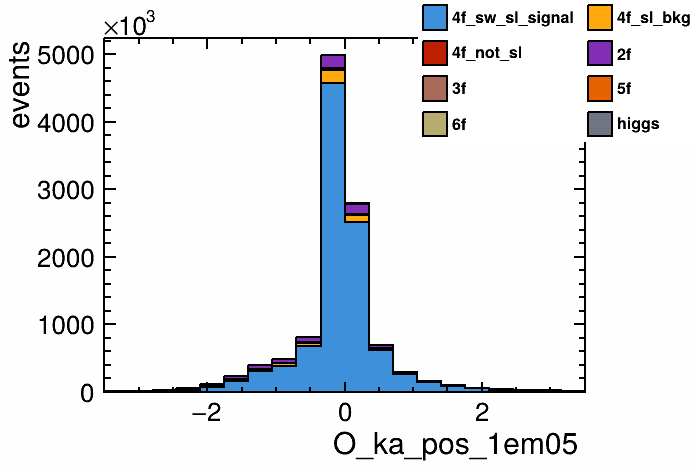

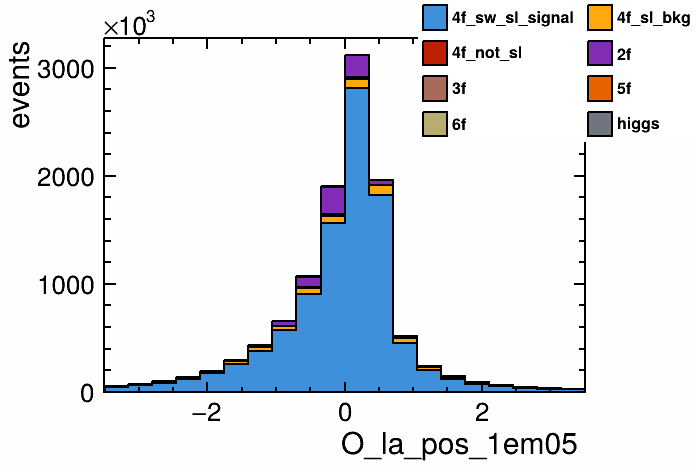

In [14]:

for name in oo_configs:
    # analysis.draw_histogram(name, categories=signal_category)
    analysis.draw_histogram(name)

Info in <TCanvas::Print>: pdf file plots/template_parametrisation/full/O_g1z_pos_1em05_4f_sw_sl_eLpL_signal_g1z.pdf has been created
Info in <TCanvas::Print>: pdf file plots/template_parametrisation/full/O_g1z_pos_1em05_4f_sw_sl_eLpL_signal_ka.pdf has been created
Info in <TCanvas::Print>: pdf file plots/template_parametrisation/full/O_g1z_pos_1em05_4f_sw_sl_eLpL_signal_la.pdf has been created
Info in <TCanvas::Print>: pdf file plots/template_parametrisation/full/O_g1z_pos_1em05_4f_sw_sl_eLpR_signal_g1z.pdf has been created
Info in <TCanvas::Print>: pdf file plots/template_parametrisation/full/O_g1z_pos_1em05_4f_sw_sl_eLpR_signal_ka.pdf has been created
Info in <TCanvas::Print>: pdf file plots/template_parametrisation/full/O_g1z_pos_1em05_4f_sw_sl_eLpR_signal_la.pdf has been created
Info in <TCanvas::Print>: pdf file plots/template_parametrisation/full/O_g1z_pos_1em05_4f_sw_sl_eRpR_signal_g1z.pdf has been created
Info in <TCanvas::Print>: pdf file plots/template_parametrisation/full/O_

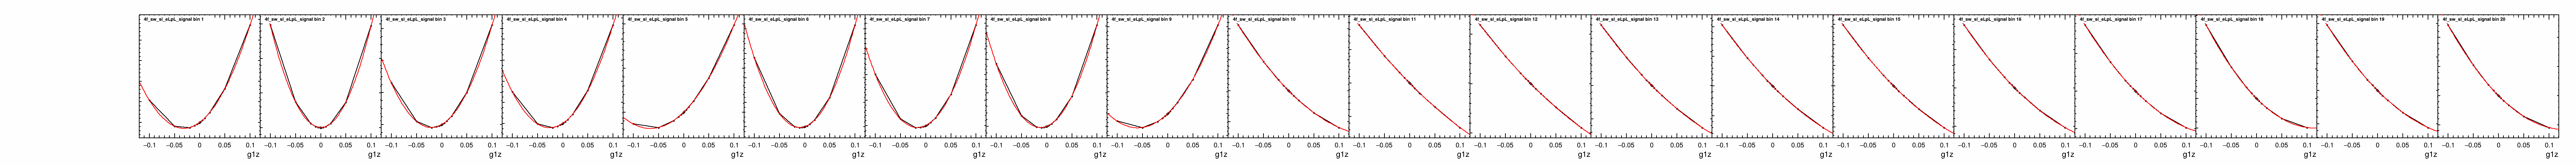

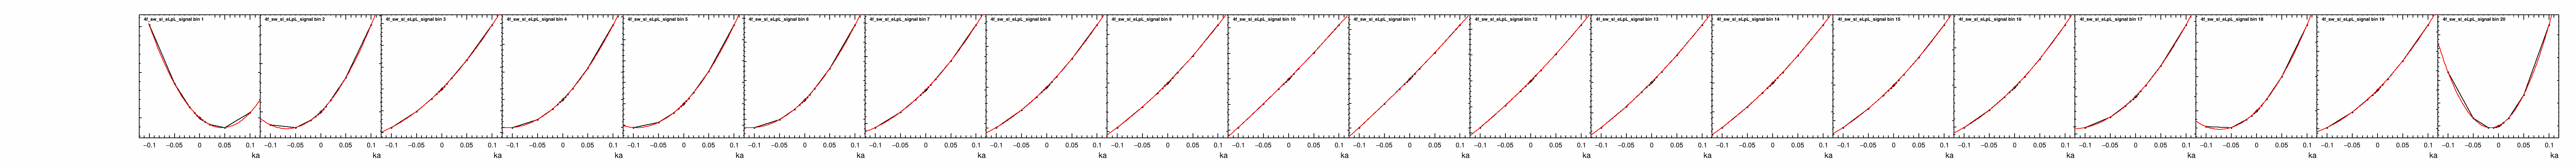

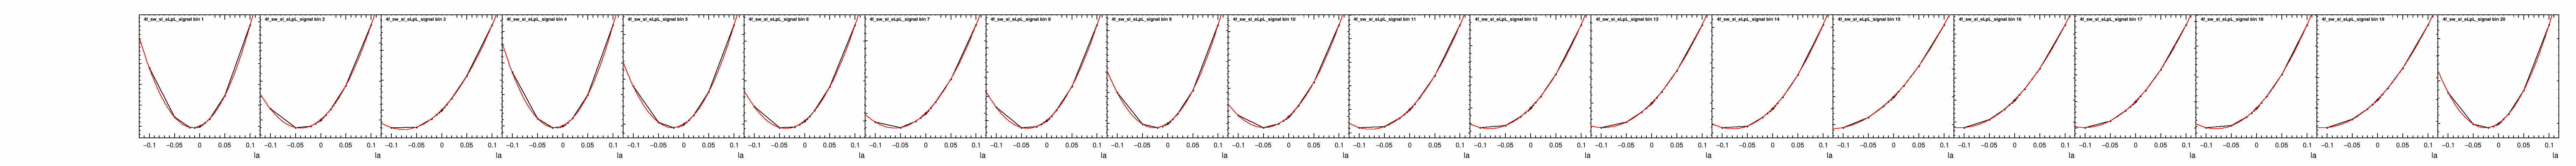

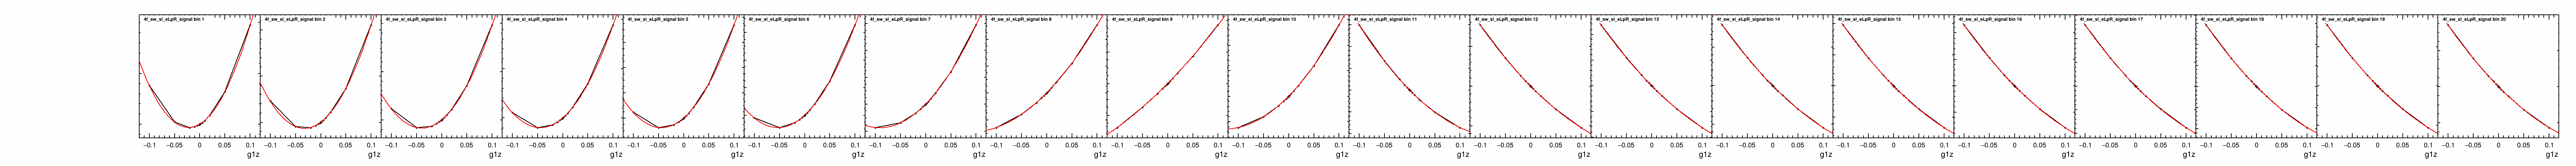

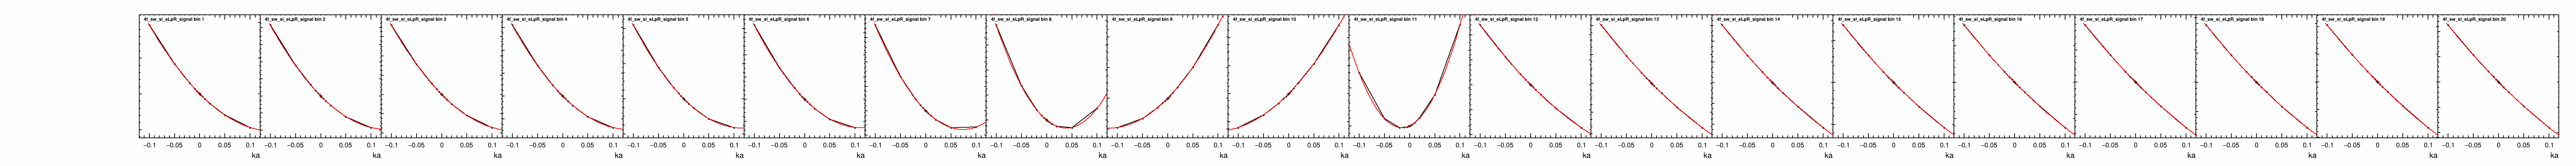

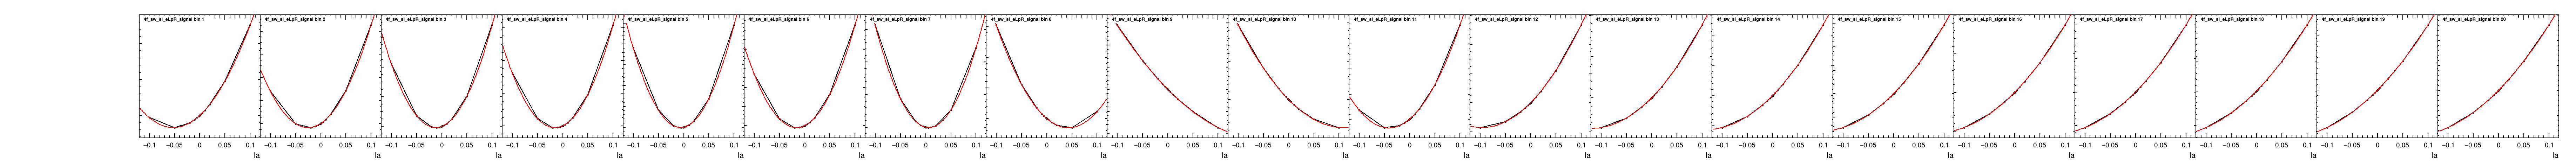

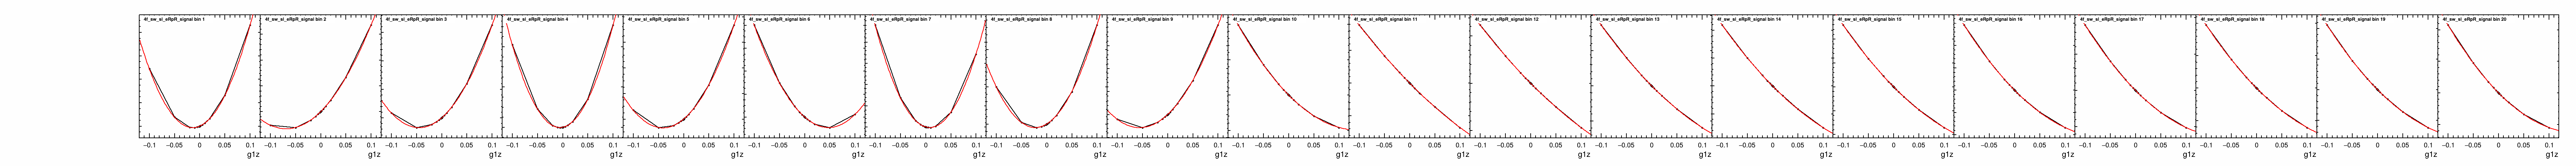

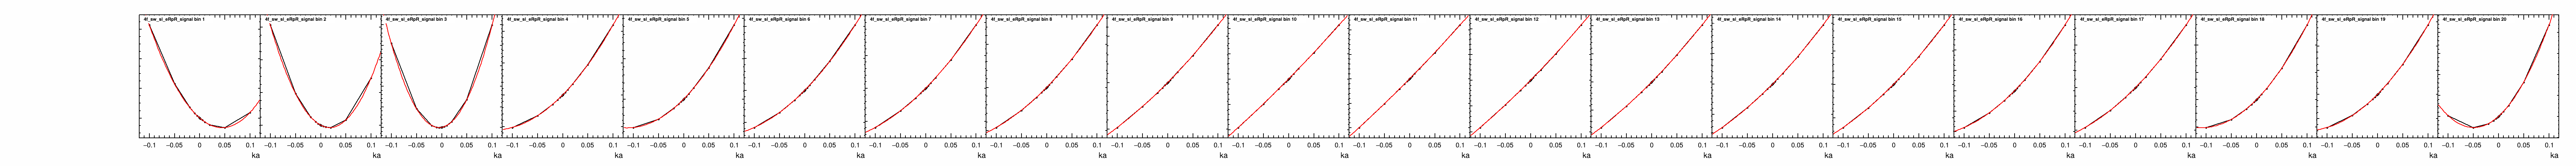

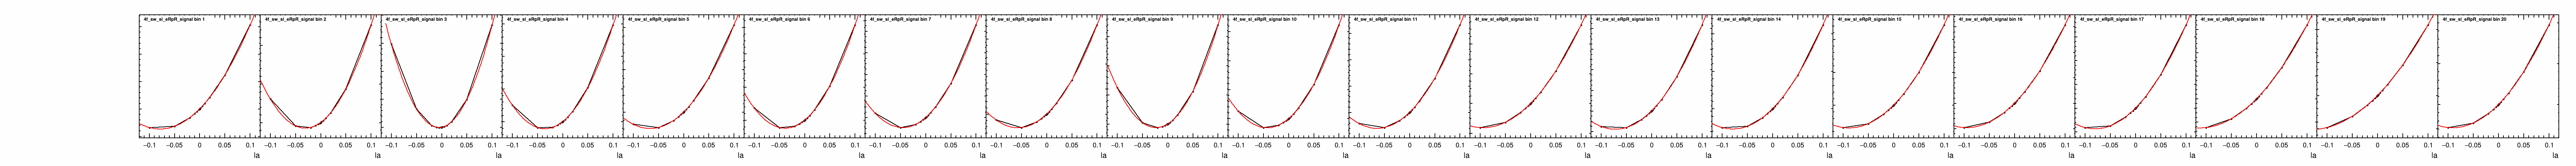

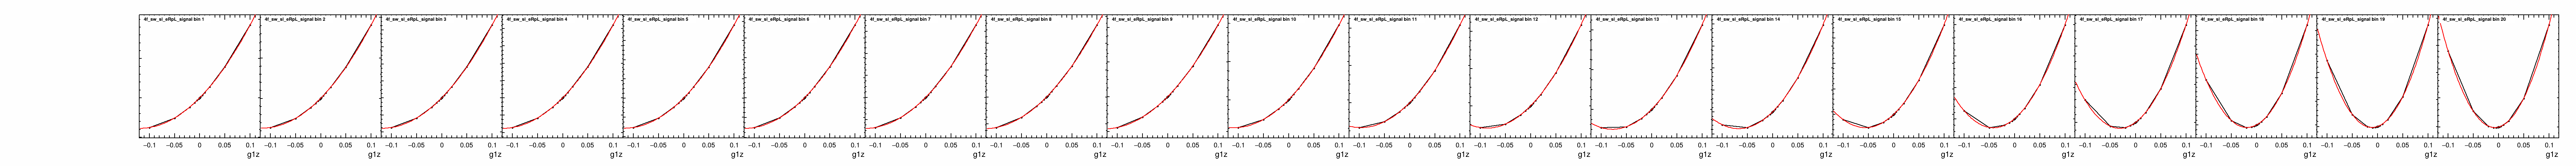

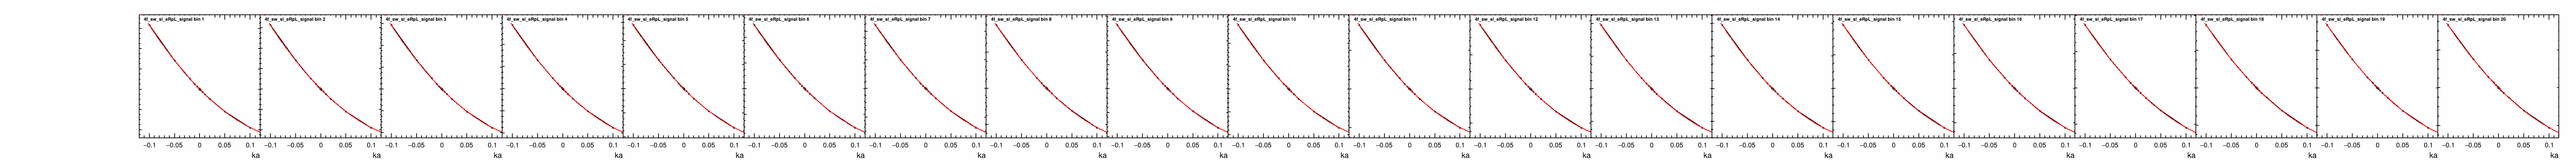

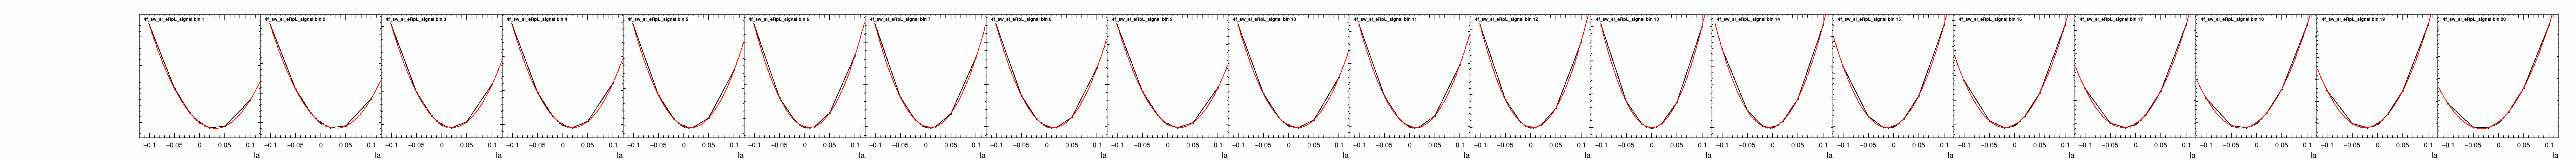

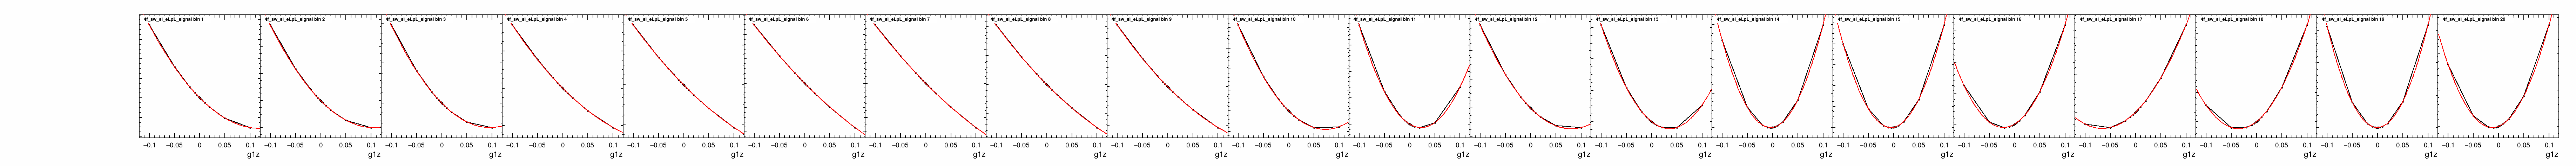

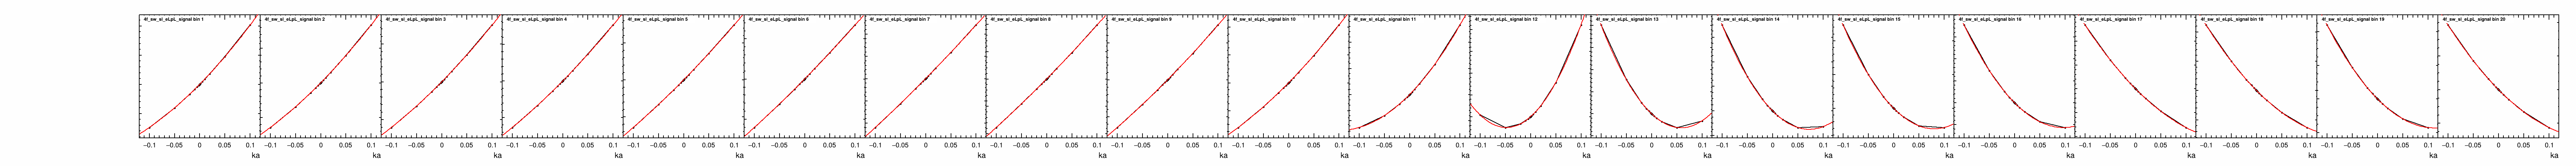

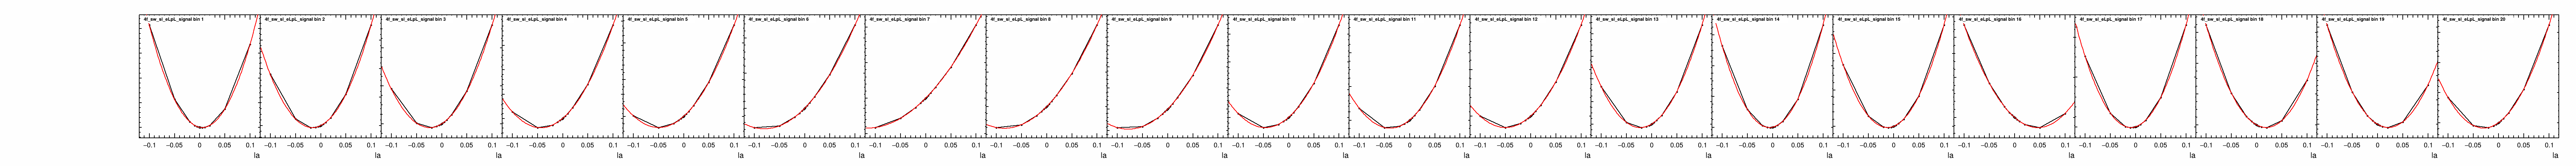

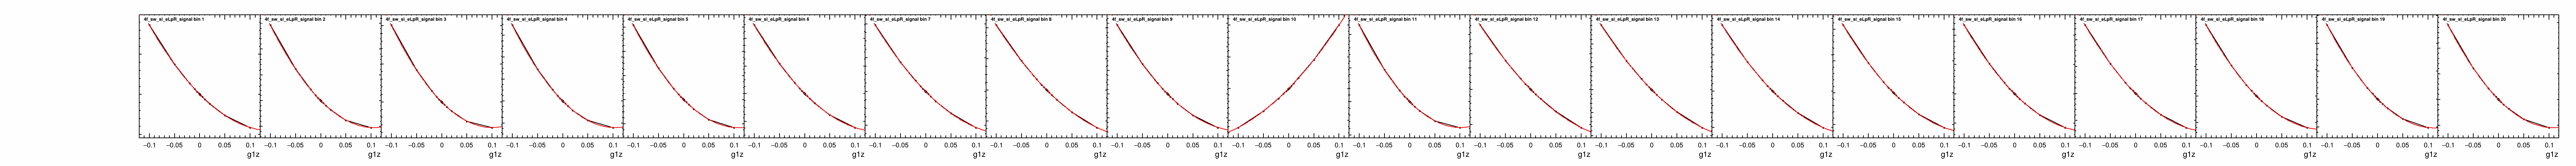

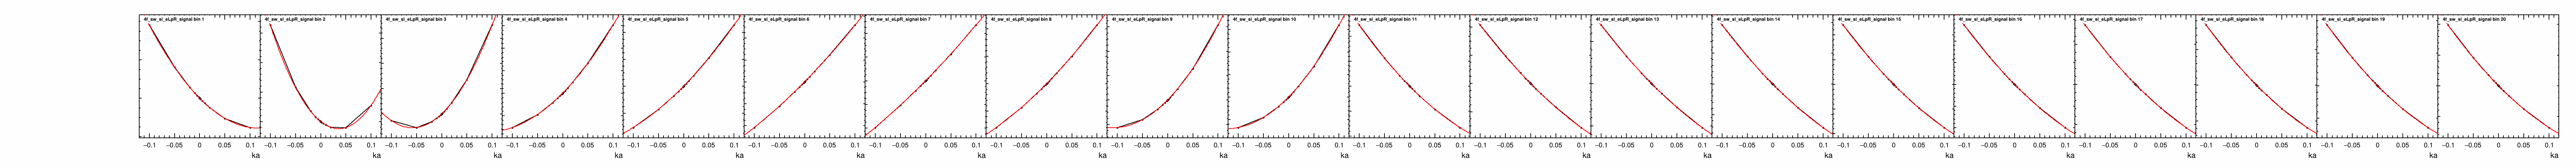

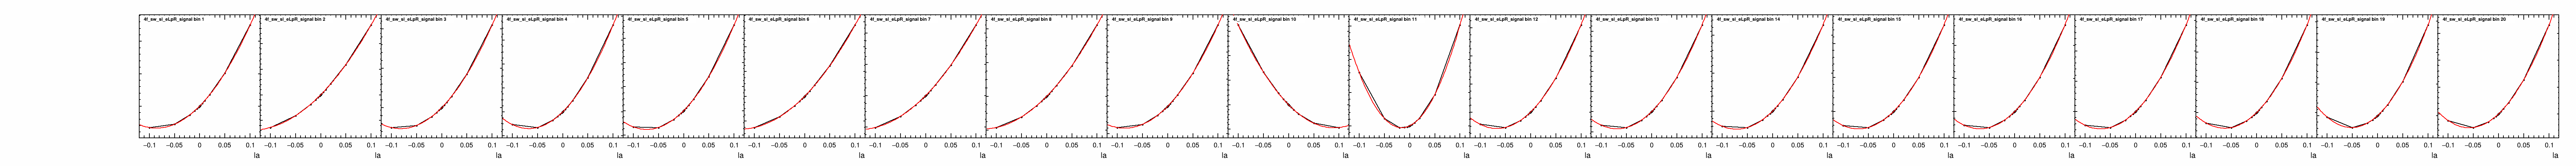

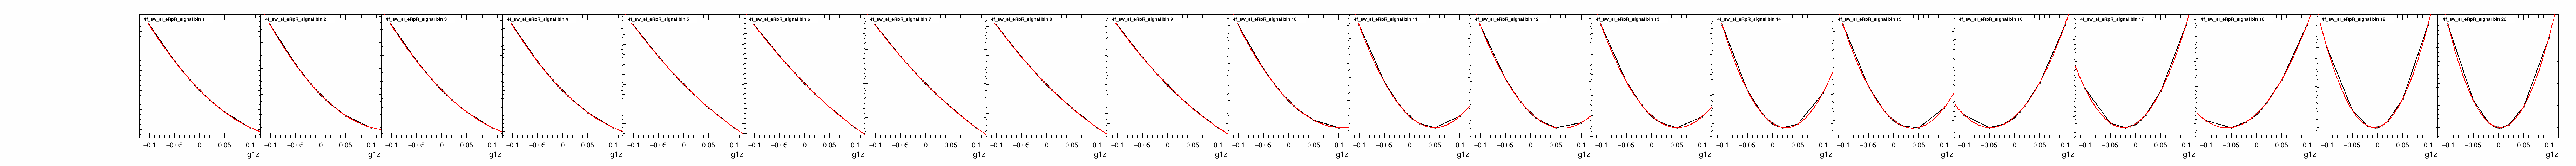

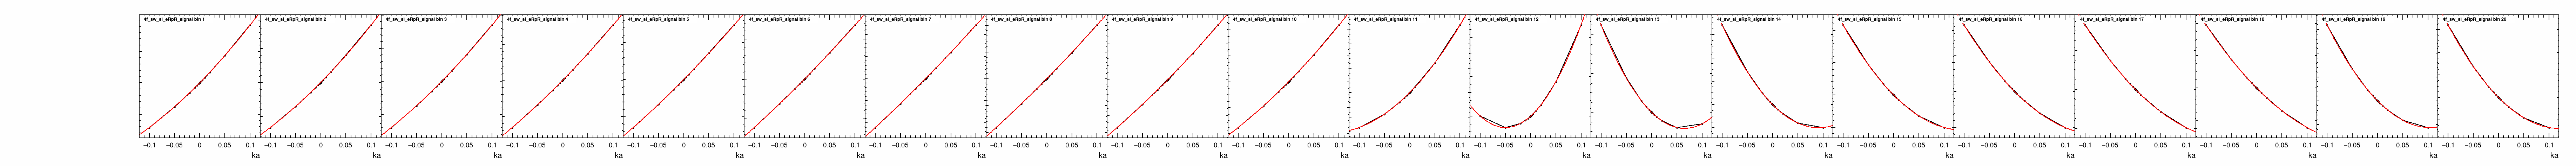

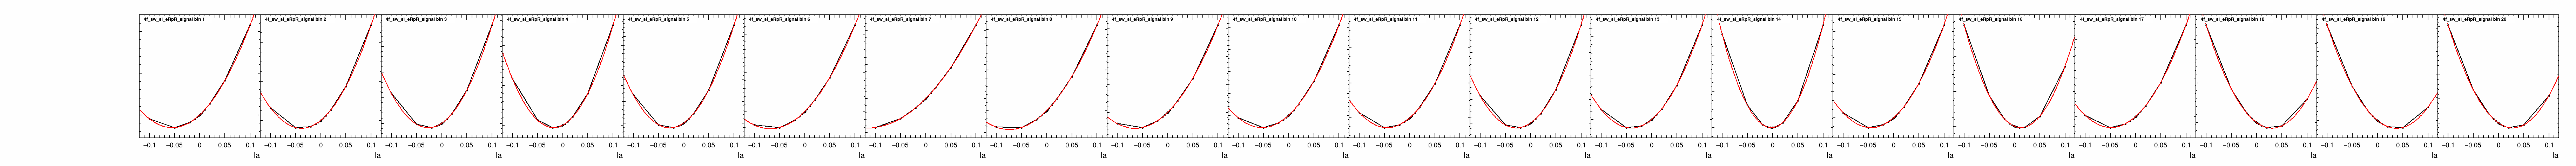

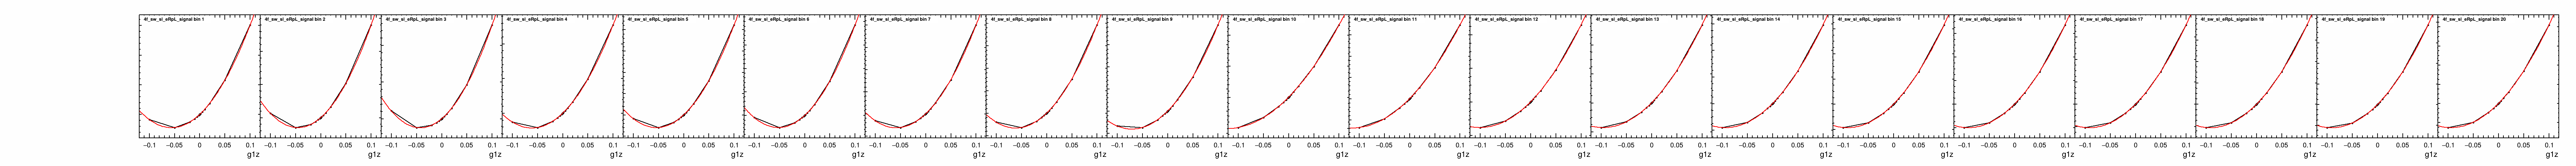

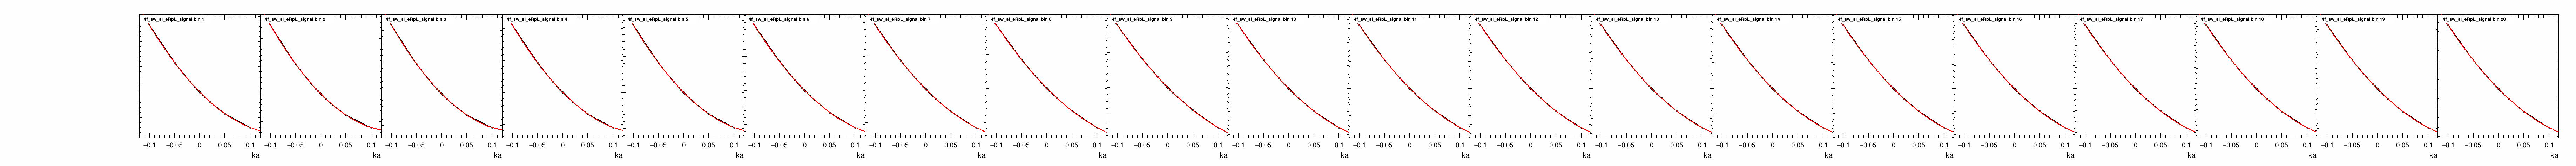

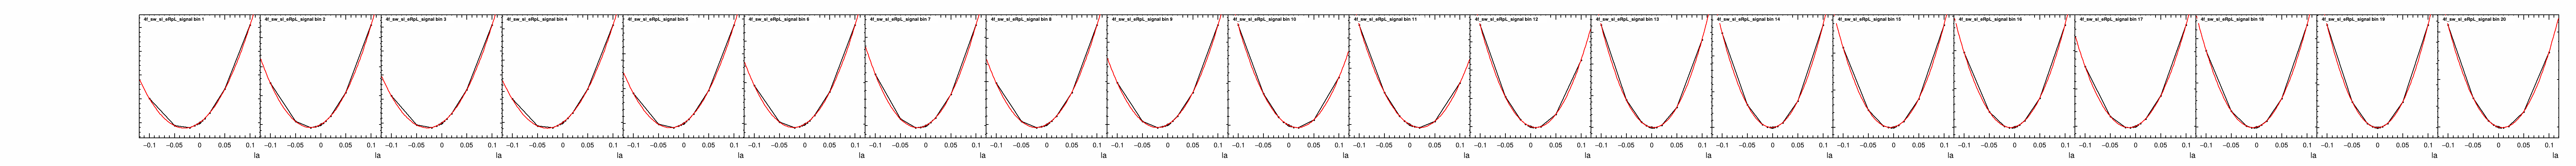

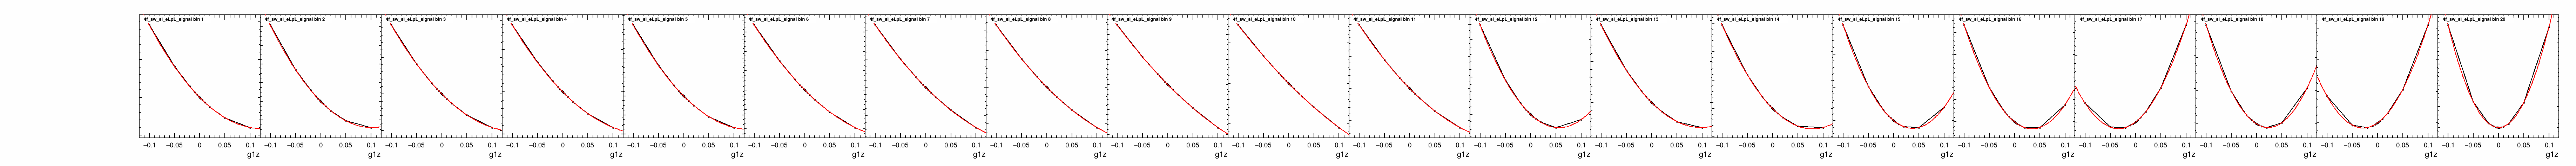

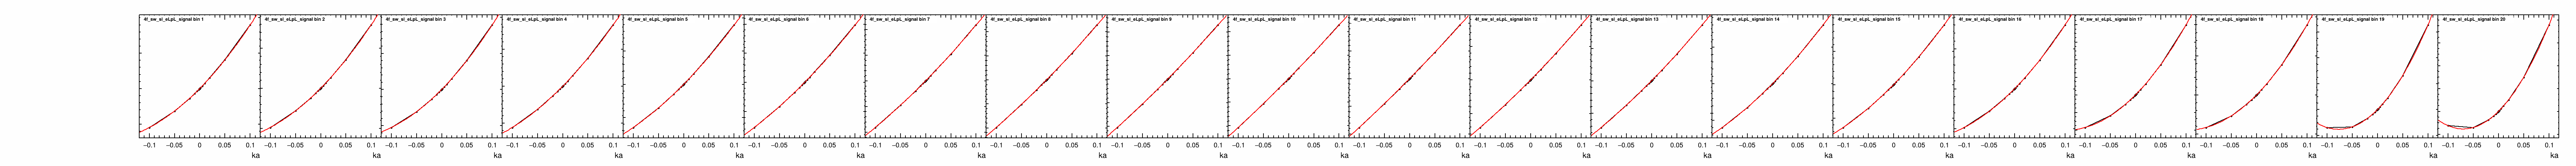

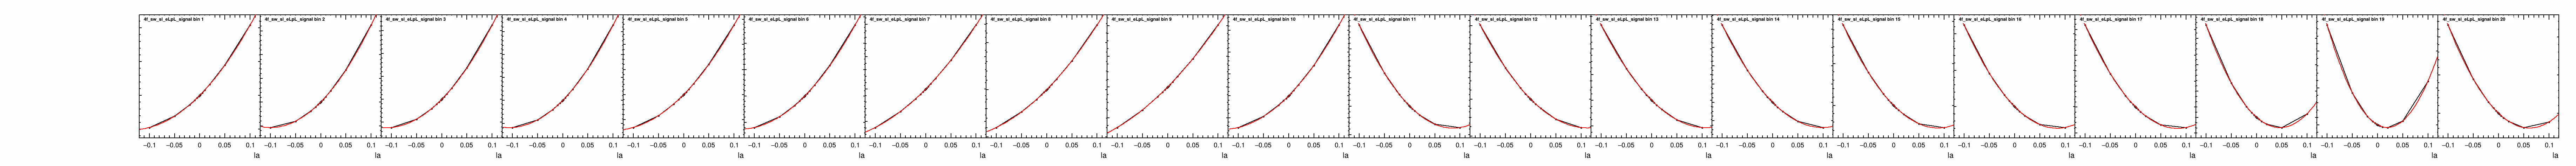

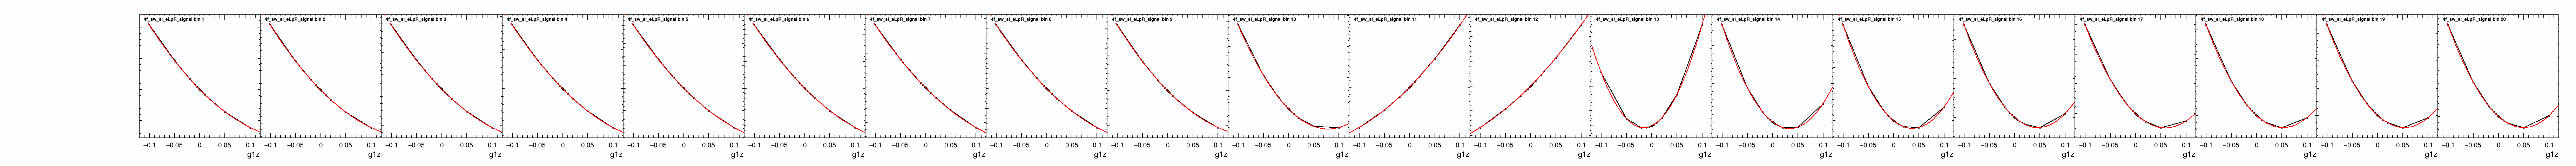

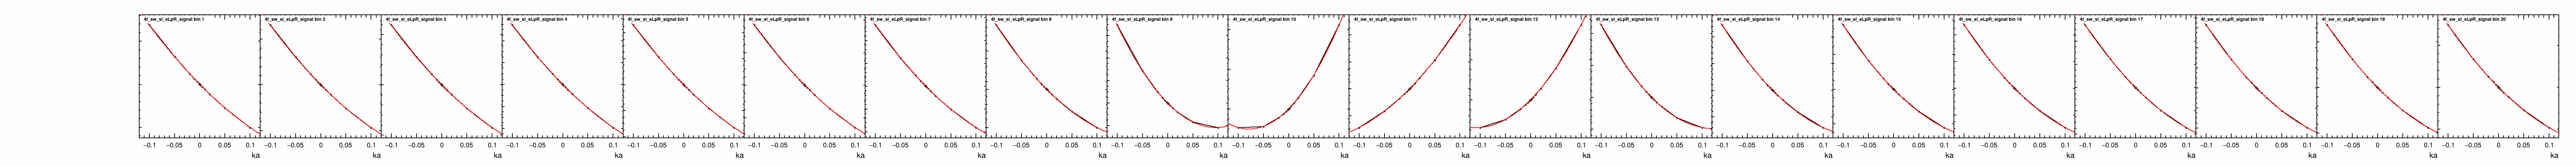

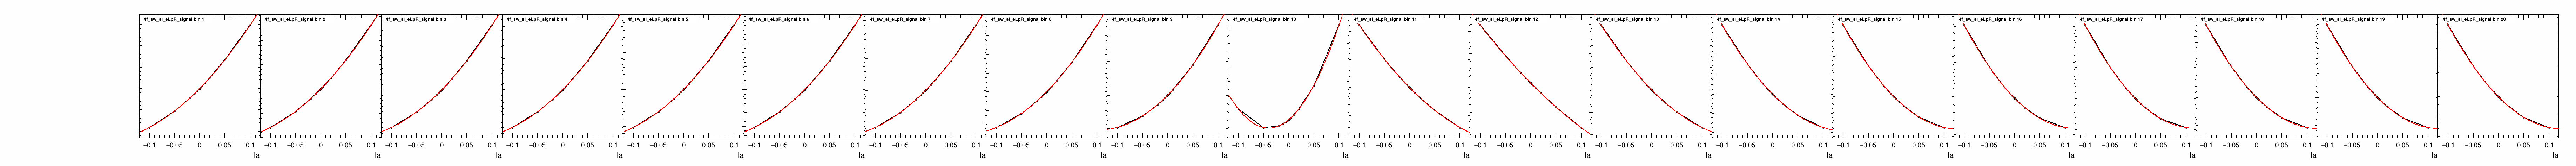

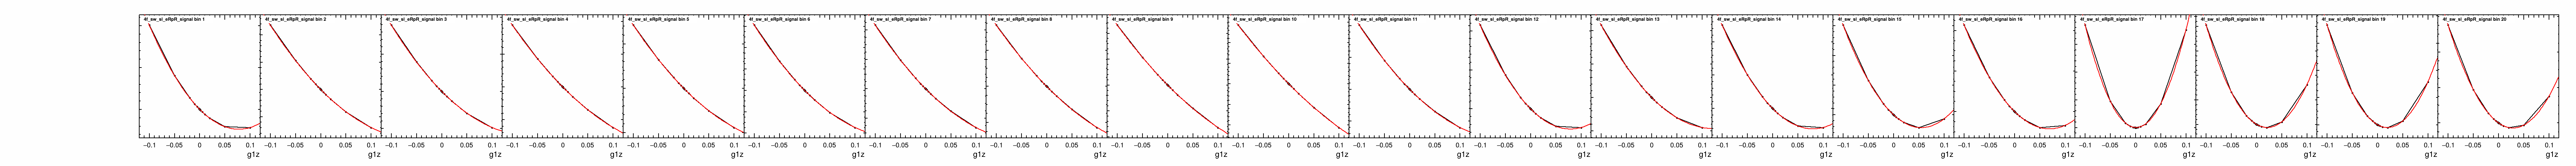

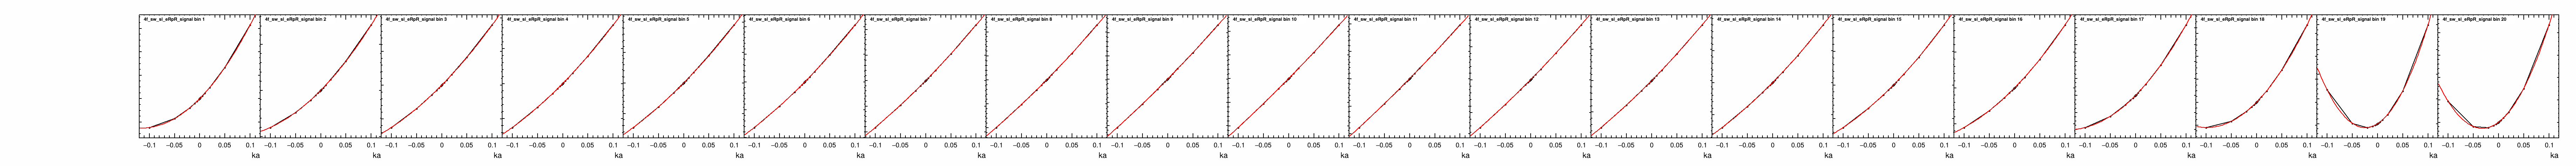

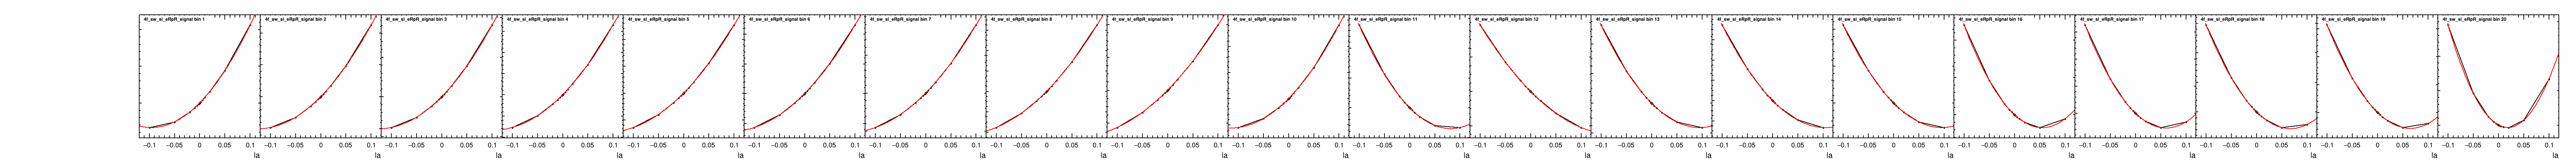

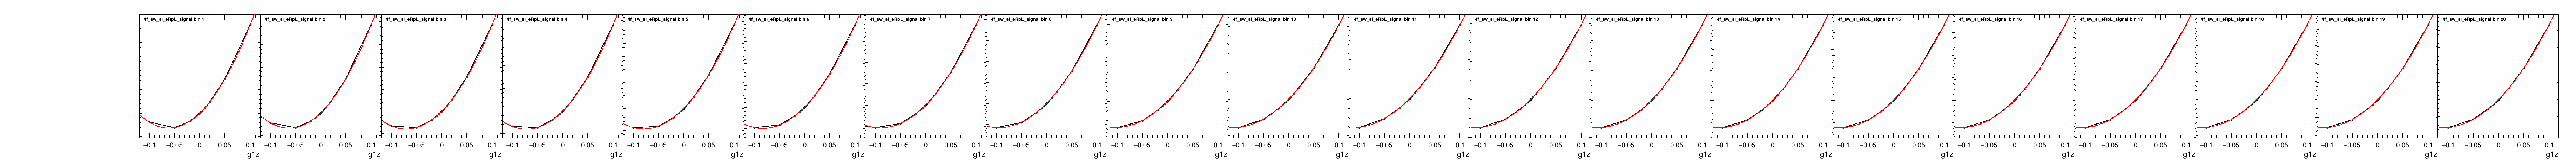

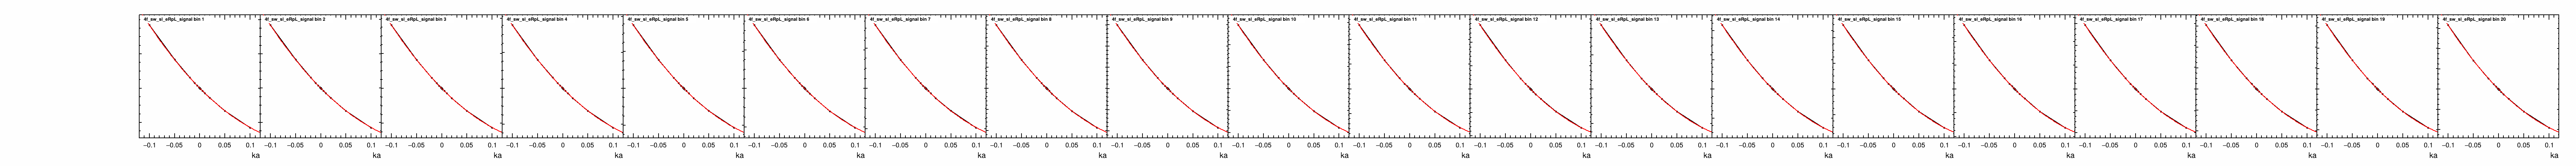

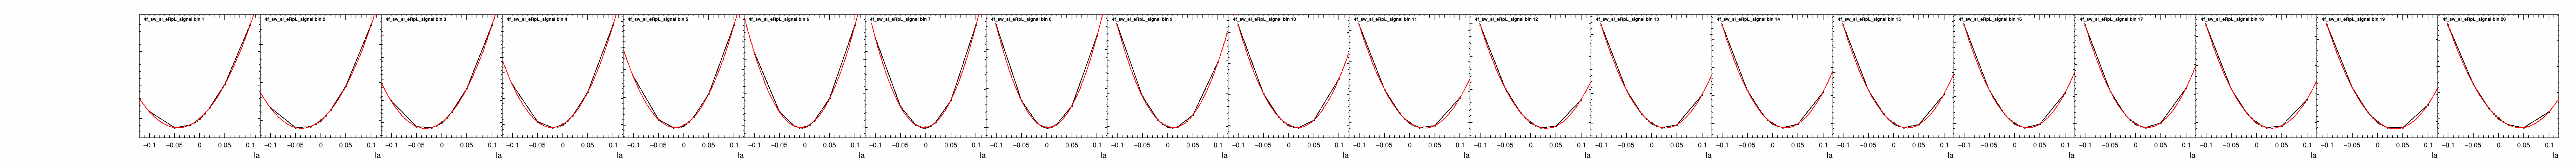

In [15]:
# analysis.plot_template_bins("O_g1z_pos_1em05", alt_setup_handler, only=oo_setups)
analysis.calculate_template_parametrisation("O_g1z_pos_1em05", alt_setup_handler)
analysis.plot_template_bins("O_g1z_pos_1em05", plot_path=template_par_plot_path)
analysis.calculate_template_parametrisation("O_ka_pos_1em05", alt_setup_handler)
analysis.plot_template_bins("O_ka_pos_1em05", plot_path=template_par_plot_path)
analysis.calculate_template_parametrisation("O_la_pos_1em05", alt_setup_handler)
analysis.plot_template_bins("O_la_pos_1em05", plot_path=template_par_plot_path)

In [16]:
analysis.write_fit_inputs(list(oo_configs.keys()), histo_path)

In [17]:
# analysis._template_pars[""]

In [18]:
print(analysis._oo_matrix["4f_sw_sl_eLpL_signal"].GetValue())
print(analysis._oo_matrix["4f_sw_sl_eLpR_signal"].GetValue())
print(analysis._oo_matrix["4f_sw_sl_eRpL_signal"].GetValue())
print(analysis._oo_matrix["4f_sw_sl_eRpR_signal"].GetValue())

{ 17206.526, -1301.2512, -13441.532, -1301.2512, 85534.664, 11954.372, -13441.532, 11954.372, 55347.421 }
{ 545300.06, 141547.68, -303905.44, 141547.68, 308056.37, -1701.5033, -303905.44, -1701.5033, 1045963.7 }
{ 979761.52, -195699.86, -248052.81, -195699.86, 839792.85, 222472.76, -248052.81, 222472.76, 1345177.6 }
{ 19602.743, -1512.7164, -15321.549, -1512.7164, 97543.797, 14125.034, -15321.549, 14125.034, 63159.555 }


In [19]:
# ROOT.gStyle.SetOptFit(1011)
# c = ROOT.TCanvas()
# graph = analysis._template_graphs["O_g1z_pos_1em05"]["4f_sw_sl_eLpR_signal"]["g1z"][0]
# graph.Draw("apl")
# c.Draw()
# c.SaveAs("example_par.pdf")